<a href="https://colab.research.google.com/github/FilipNikolic01/PPPO/blob/main/PPPO_FilipNikolic_IT42_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikacija slika

Klasifikacija slika (ili identifikacija slika) jedan je od pionirskih primera upotrebe dubokog učenja. Cilj zadatka je obučiti model sposoban da identifikuje glavni objekat interesa na slici.

Klasifikacija objekata za ljude je lak zadatak, ali pokazalo se  da  predstavlja  složen problem za mašine. Porast računara velikog kapaciteta, dostupnost visokokvalitetnih i  jeftinih  video  kamera,  kao  i  sve  veća  potreba  za automatskom video analizom, izazvali su interesovanje za algoritme klasifikacije objekata. Danas  je  uz  pomoć  učenja  iz  podataka,  prepoznavanje slika postalo veoma efikasno. Ova je metoda mašinskog učenja dizajnirana po uzoru na funkcionisanje ljudskog mozga.

#Konvolucijske neuronske mreže

Konvolucijske neuronske mreže (engl.Convolutional neural network-CNN) predstavljaju aktuelan i istraživački atraktivan domen u širokoj oblasti veštačke inte-ligencije (eng. Artificial Intelligence –AI). Konvoluciona neuronska mreža je dobila ime po konvoluciji, široko korišćenom operatoru, koji se primenjuje u obradi slike i signala.

Ideja konvolucione neuronske mreže jeste da se postavi veći broj slojeva za otkrivanje bitnih osobina ulaznih podataka. U skladu sa tom idejom se konvolucioni filteri primenjuju na sliku kako bi se izvukle korisne karakteristike i kreirale njihove mape (eng. feature maps). Primenom filtera na ulaznu sliku, pored otkrivanja značajnih karakteristika, vrši se i redukcija rezolucije.

Nedostatak konvolucione neuronske mreže jeste potreba za značajnim hardverskim resursima, kao i to što su dosadašnji modeli obučavani velikim brojem slika, ali noviji rezultati sugerišu da se visoke performanse mogu postići i sa relativnom malim brojem uzoraka.

Uzmimo u obzir sliku veličine 256 × 256. Umesto obrade cele slike odjednom, CNN može efikasno pregledavati sličicu po sličicu - recimo, kroz okvir veličine 5 × 5. Okvir 5 × 5 klizi duž slike (obično s leva na desno i odozgo prema dole), kako je prikazano na slici ispod. Koliko "brzo" klizi naziva se dužina koraka (stride length). Na primer, dužina koraka od 2 znači da se prozor 5 × 5 pomera za 2 piksela svaki put dok ne obuhvati celu sliku.

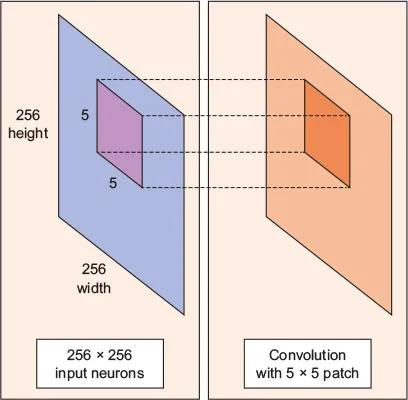

# Kreiranje modela za klasifikaciju pasa

> U nastavku će biti detaljno opisano kreiranje modela koji na osnovu prikazene fotografije psa određuje kojoj rasi taj pas pripada.

Pre toga, potrebno je importovati Pythob biblioteke koje će se koristiti u okviru ovog projekta. **TensorFlow** je open-source biblioteka koja se koristi za dotreniranje postojećih neuralnih mreža, kao i za kreiranje sopstvenih. TensorFlow se može koristiti u različitim programskim jezicima, uključujući Python, JavaScript, C++ i Java, olakšavajući njegovu primenu u različitim aplikacijama u mnogim sektorima.

# Importovanje Python paketa

Importovanje svih paketa(biblioteka) koje će biti potrebne u nastavku rada.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd

import time
from datetime import timedelta

import math
import os

import scipy.misc
from random import sample
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Manipulacija slikama
import PIL.Image
from IPython.display import display

# Otvaranje ZIP fajlova
from zipfile import ZipFile
from io import BytesIO

# Povezivanje Google Drive-a, gde će se nalaziti dataset
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Dataset/

#Upload dataseta na Google Drive
from google.colab import files
uploaded = files.upload()

Instructions for updating:
non-resource variables are not supported in the long term


Mounted at /content/drive
/content/drive/MyDrive/Dataset


# Otpakivanje fajlova

Sada nam je potrebno izvući (extract) train i test fajlove iz ZIP arhive. Ovo je kod:

In [ ]:
# Raspakivanje ZIP arhiva sa train i test fajlovima
archive_train = ZipFile("/content/drive/MyDrive/Dataset/train.zip", 'r')
archive_test = ZipFile("/content/drive/MyDrive/Dataset/test.zip", 'r')

# Ova linija prikazuje prvih 5 naziva slika u trening bazi
archive_train.namelist()[0:5]

# Ova linija prikazuje broj slika koje se nalaze u trening bazi, trebamo obrisati prvu vrednost (naziv kolone)
len(archive_train.namelist()[:]) - 1

10222

# Promena veličine i normalizovanje podataka

>Funkcija ispod kreira pickle fajl kako bi sačuvala sve slike raspakovane iz ZIP arhive. Pickle se može koristiti za serijalizaciju struktura objekata u Pythonu, što se odnosi na proces pretvaranja objekta u memoriji u niz bajtova koji se mogu sačuvati kao binarni fajl na disku.

>Nemaju sve slike isti oblik. Za naš model, moramo ih promeniti tako da imaju isti oblik. Koristimo uobičajenu praksu da ih oblikujemo kao kvadrat. Takođe, moramo normalizovati naš skup podataka tako što ćemo podeliti sve vrednosti piksela sa 255. Nove vrednosti piksela će biti u opsegu [0,1].

In [ ]:
# Funkcija koja kreira pickle fajl koji prikuplja sve slike iz zip foldera i vrši promenu veličine slika (nwidth i nheight parametri)

def DataBase_creator(archivezip, nwidth, nheight, save_name):

  #Koristimo arhivu i novu širinu i dužinu za sve slike

  # Start-time i kasnije End-time se koriste za beleženje vremena koje je potrebno da se funkcija obavi
  start_time = time.time()

  # nwidth x nheight = broj karakteristika (feature-a) jer slike imaju širinu x visiunu piksela
  s = (len(archivezip.namelist()[:]) -1, nwidth, nheight, 3)
  allImage = np.zeros(s)
  for i in range(1, len(archivezip.namelist()[:])):
    filename = BytesIO(archivezip.read(archivezip.namelist()[i]))
    image = PIL.Image.open(filename)
    image = image.resize((nwidth, nheight))
    image = np.array(image)
    image = np.clip(image / 255.0, 0.0, 1.0)
    allImage[i-1] = image

  # Čuvanje novonastale baze podataka(slika)
  pickle.dump(allImage, open(save_name + '.p', "wb"))

  # Računanje vremena koje je bilo potrebno da se izvrši prethodna funkcija
  end_time = time.time()
  time_diff = end_time - start_time
  print("Utrošeno vreme: " + str(timedelta(seconds = int(round(time_diff)))))

Sada ćemo definisati novu veličinu fotografija i nakon toga pozvati prethodno kreiranu funkciju. Kod prvog pokušaja slike su smanjene na 60x60 veličnu. Međutim, kvalitet slike je drastično opao tako da smo ponovo učitali slike iz arhive i stavili veličinu 120x120. Time se kvalitet slike poboljšao ali je kreiranje pickle fajla i promena veličine znatno duže trajala.

In [ ]:
image_resize = 60

DataBase_creator(archivezip = archive_train, nwidth = image_resize, nheight = image_resize, save_name = "train")
DataBase_creator(archivezip = archive_test, nwidth = image_resize, nheight = image_resize, save_name = "test")

Utrošeno vreme: 0:01:14
Utrošeno vreme: 0:01:22


In [ ]:
# Učitavanje trening slika
train = pickle.load(open("train.p", "rb"))
train.shape

(10222, 60, 60, 3)

In [ ]:
# Učitavanje test slika
test = pickle.load(open("test.p", "rb"))
test.shape

(10357, 60, 60, 3)

>Prikazivanje jedne slike iz trening seta slika

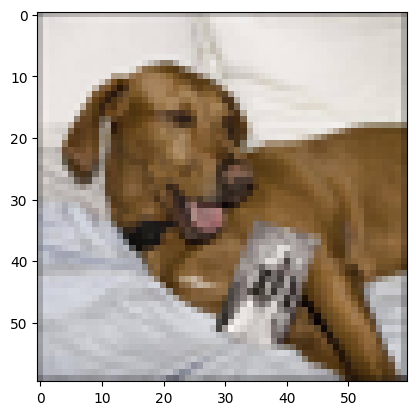

In [ ]:
lum_img = train[100,:,:,:]
plt.imshow(lum_img)
plt.show()

# Labels fajl i najčešće zastupljene rase

Sada ćemo proveriti labels fajl koji sadrži rasu za svakog psa u trening setu.


In [ ]:
labels_raw = pd.read_csv("/content/drive/MyDrive/Dataset/labels.zip", compression = 'zip', header = 0, sep = ',', quotechar = '"')
labels_raw.sample(5)

,id,breed
2308,398dfd60791dde4f6e638d8a812325dc,french_bulldog
2348,3a5ee5179351ec35c761ca460a6ffa20,pomeranian
7954,c6dbaa6aac1d6c5186dbdc19ec043f5f,briard
4187,6815af65031d53e092f1dc7f2e6f36db,bloodhound
3703,5c4e40f3302df35ba2ca23d0d7e195c4,bouvier_des_flandres


Sledeći kod prikazuje 20 rasa koje su najzastupljenije u trening setu

In [ ]:
print("Top 20 najzastupljenijih rasa (sortirani po broju slika za svaku rasu): ")
(labels_raw.groupby("breed").count().sort_values("id", ascending = False).head(20))

Top 20 najzastupljenijih rasa (sortirani po broju slika za svaku rasu): 


,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


>Smanjićemo bazu podataka kako bismo smanjili kompleksnost našeg modela. Takođe, manji broj rasa će pomoći pri računanju jer će postojati samo N rasa za klasifikaciju. Moći ćemo lako pokrenuti model u manje od 10 minuta.

In [ ]:
number_of_breads = 8

def main_breeds(labels_raw, number_breads, all_breads = 'TRUE'):
  values, counts = np.unique(labels_raw["breed"], return_counts = True)
  labels_freq_pd = np.column_stack((values, counts))
  labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]]

  if all_breads == 'FALSE':
    main_labels = labels_freq_pd[:, 0][0: number_breads]
  else:
    main_labels = labels_freq_pd[:, 0][:]

  labels_raw_np = labels_raw["breed"].to_numpy()
  labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0], 1)
  labels_filtered_index = np.where(labels_raw_np == main_labels)
  return labels_filtered_index

labels_filtered_index = main_breeds(labels_raw = labels_raw, number_breads = number_of_breads, all_breads='FALSE')
labels_filtered = labels_raw.iloc[labels_filtered_index[0], :]
train_filtered = train[labels_filtered_index[0], :, :, :]
print('Broj slika koji je ostao nakon odabira {0} najpopularnijih rasa: {1}'.format(number_of_breads, labels_filtered_index[0].shape))
print('Oblik filtriranog trening seta je: {0}'.format(train_filtered.shape))

Broj slika koji je ostao nakon odabira 8 najpopularnijih rasa: (922,)
Oblik filtriranog trening seta je: (922, 60, 60, 3)


>Prikazivanje jedne slike iz filtriranog trening seta

<function matplotlib.pyplot.show(close=None, block=None)>

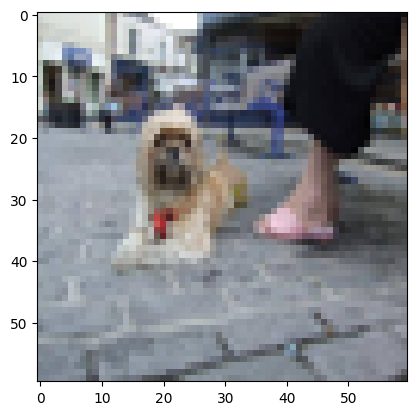

In [ ]:
lum_img = train_filtered[100, :, :, :]
plt.imshow(lum_img)
plt.show

# One-Hot Label (One-Hot-Encoding)

One-hot encoding je tehnika koju koristimo da predstavimo kategoričke promenljive kao numeričke vrednosti u modelu mašinskog učenja.

Prednosti korišćenja one-hot encoding-a uključuju:
- Omogućava upotrebu kategoričkih promenljivih u modelima koji zahtevaju numerički ulaz.
- Može poboljšati performanse modela pružanjem više informacija modelu o kategoričkoj promenljivoj.
- Može pomoći u izbegavanju problema ordinalnosti, koji može nastati kada kategorička promenljiva ima prirodno uređivanje (npr. "malo", "srednje", "veliko").

> Sada ćemo da uradimo one-hot encoding za naš labels fajl

In [ ]:
# Uzimamo labele (vrednosti) od 8 nazastupljenijih rasa
labels = labels_filtered["breed"].to_numpy()
labels = labels.reshape(labels.shape[0], 1)

labels.shape

(922, 1)

In [ ]:
# Funkcija koja kreira one-hot labele
def matrix_Bin(labels):
  labels_bin = np.array([])

  labels_name, labels0 = np.unique(labels, return_inverse = True)
  labels0

  values, counts = np.unique(labels0, return_counts = True)
  labels0_freq = np.column_stack((values, counts))

  for _, i in enumerate(labels0_freq[:, 0].astype(int)):
    labels_bin0 = np.where(labels0 == labels0_freq[:, 0][i], 1., 0.)
    labels_bin0 = labels_bin0.reshape(1, labels_bin0.shape[0])

    if (labels_bin.shape[0] == 0):
      labels_bin = labels_bin0
    else:
      labels_bin = np.concatenate((labels_bin, labels_bin0), axis = 0)

  print("Broj podvariabli (rasa): {0}".format(labels0_freq [:, 0].shape[0]))
  labels_bin = labels_bin.transpose()
  print("Oblik: {0}".format(labels_bin.shape))

  return labels_name, labels_bin

In [ ]:
labels_name, labels_bin = matrix_Bin(labels = labels)
labels_bin[0:9]

Broj podvariabli (rasa): 8
Oblik: (922, 8)


array([[0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.]])

In [ ]:
for breed in range(len(labels_name)):
  print('Rasa {0}: {1}'.format(breed + 1, labels_name[breed]))

Rasa 1: afghan_hound
Rasa 2: bernese_mountain_dog
Rasa 3: entlebucher
Rasa 4: great_pyrenees
Rasa 5: maltese_dog
Rasa 6: pomeranian
Rasa 7: scottish_deerhound
Rasa 8: shih-tzu


> U kodu iznad je prikazana reprezentacija rasa preko one-hot encodinga. Kao što vidimo, u svakom redu u matrici imamo samo jednu vrednost koja je 1 (one-hot), dok su ostale vrednosti 0. U prvom redu one-hot kolona je kolona 7 (6 ukoliko posmatramo u smislu dvodimenzionalnih nizova u programskom jeziku Python), što znači da prva labela pripada rasi škotskog jelenskog hrta (eng. *scottish deerhound*)

In [ ]:
labels_cls = np.argmax(labels_bin, axis = 1)
labels[0:9]

array([['scottish_deerhound'],
       ['maltese_dog'],
       ['shih-tzu'],
       ['scottish_deerhound'],
       ['entlebucher'],
       ['entlebucher'],
       ['maltese_dog'],
       ['bernese_mountain_dog'],
       ['entlebucher']], dtype=object)

# Konvolucione neuronske mreže - Praktični deo

1 - Kreiranje skupa podataka za obuku i validaciju

> Delimo naše podatke za obuku na dva dela: skup za obuku i skup za validaciju. Na taj način možemo proveriti tačnost modela, koji je obučen na skupu za obuku, na validacionom skupu.

In [ ]:
num_validation = 0.30

X_train, X_validation, y_train, y_validation = train_test_split(train_filtered, labels_bin, test_size = num_validation, random_state = 6)

2 - Kreiranje skupa podataka za obuku i testiranje
> Ispod je prikazan kod za deljenje originalnih podataka na skupove za obuku i testiranje.

In [ ]:
def train_test_creation(x, data, toPred):
  indicies = sample(range(data.shape[0]), int(x * data.shape[0]))
  indicies = np.sort(indicies, axis = None)

  index = np.arange(data.shape[0])
  reverse_index = np.delete(index, indicies, 0)

  train_toUse = data[indicies]
  train_toPred = toPred[indicies]
  test_toUse = data[reverse_index]
  test_toPred = toPred[reverse_index]

  return train_toUse, train_toPred, test_toUse, test_toPred

df_train_toUse, df_train_toPred, df_test_toUse, df_test_toPred = train_test_creation(0.7, train_filtered, labels_bin)

df_validation_toPred_cls = np.argmax(y_validation, axis = 1)
df_validation_toPred_cls[0:9]

array([5, 1, 5, 6, 7, 2, 5, 1, 1])

3 - CNN sa TensorFlow-om - Definisanje slojeva
>Arhitektura će izgledati ovako:

1. Prvi konvolutivni sloj sa 32 filtera
   - Maksimalno uzorkovanje
   - ReLU aktivaciona funkcija

2. Drugi konvolutivni sloj sa 64 filtera
   - Maksimalno uzorkovanje
   - ReLU aktivaciona funkcija

3. Treći konvolutivni sloj sa 128 filtera
   - Maksimalno uzorkovanje
   - ReLU aktivaciona funkcija
   - Sloj isključivanja (DropOut)

4. Sloj poravnanja
5. Potpuno povezani sloj sa 500 čvorova
   - ReLU aktivaciona funkcija
   - Sloj isključivanja (DropOut)

6. Potpuno povezani sloj sa n čvorova (n = broj rasa)

>Ukratko objašnjenje prethodno navedenih termina:

- Konvolutivni sloj: U ovom sloju čuvamo prostorni odnos između piksela učenjem karakteristika slike pomoću malih kvadrata ulaznih podataka. Ovi kvadrati ulaznih podataka nazivaju se filterima ili jezgrima (kernels). Matrica koja se formira klizanjem filtera preko slike i računanjem skalarnog proizvoda naziva se Mapa karakteristika (Feature Map). Što više imamo filtera, više se karakteristika slike "izvlači" i naša mreža postaje bolja u prepoznavanju obrazaca na slikama koje još nisu prikazane.

- ReLU sloj: Da bi bila snažna, svaka vrsta neuronske mreže mora biti nelinearna. ReLU je nelinearna operacija, što znači Rectified Linear Unit. To je element-po-element operacija koja zamenjuje sve negativne vrednosti piksela u mapi karakteristika sa 0. Rezultat iz konvolutivnog sloja prolazi kroz ReLU aktivacionu funkciju.

- Sloj maksimalnog uzorkovanja: Nakon toga, vršimo operaciju uzorkovanja kako bismo smanjili dimenzionalnost svake mape karakteristika. To nam omogućava smanjenje broja parametara i računanja u mreži, čime se kontroliše preprilagođavanje. CNN koristi maksimalno uzorkovanje, pri čemu definiše prostorno susedstvo i uzima najveći element iz izravnate mape karakteristika unutar tog prozora. Nakon sloja uzorkovanja, naša mreža postaje invarijantna na male transformacije, izobličenja i translacije na ulaznoj slici.

- Potpuno povezani sloj: Nakon ovih slojeva, dodajemo nekoliko potpuno povezanih slojeva kako bismo zaokružili arhitekturu CNN-a. Izlaz iz konvolutivnih i slojeva uzorkovanja predstavlja karakteristike ulazne slike visokog nivoa. Potpuno povezani slojevi koriste ove karakteristike za klasifikaciju ulazne slike u različite klase na osnovu trening skupa podataka. Osim klasifikacije, dodavanje potpuno povezanih slojeva pomaže i u učenju nelinearnih kombinacija ovih karakteristika.

- Sloj isključivanja (Droput): Dropout je tehnika regularizacije koja pomaže mreži da izbegne preprilagođavanje. Tokom obuke, polovina neurona na određenom sloju će biti deaktivirana. Ovo poboljšava generalizaciju jer prisiljavate sloj da uči sa različitim neuronima. Obično koristimo Dropout na potpuno povezanim slojevima, ali takođe je moguće koristiti Dropout nakon slojeva maksimalnog uzorkovanja, stvarajući neku vrstu augmentacije šuma slike.

> Sa šireg gledišta, arhitektura CNN-a izvršava dva glavna zadatka: ekstrakciju karakteristika (konvolucioni + slojevi uzorkovanja) i klasifikaciju (potpuno povezani slojevi). Generalno, što više koraka konvolucije imamo, to će naša mreža moći prepoznavati složenije karakteristike.

> Ovde definišemo težine, pristrasnosti i ostale konstante

In [ ]:
# Naše slike su 120x120 piksela
img_size = image_resize

# Broj kanala za svaku sliku
num_channels = 3

# Slike se čuvaju u jednodimenzionalnom nizu sledeće dužine
img_size_flat = img_size * img_size

# Oblik slike
img_shape = (img_size, img_size, num_channels)

# Broj klasa
num_classes = number_of_breads

def new_weights(shape):
  return tf.Variable(tf.truncated_normal(shape, stddev = 0.05))
  # Generiše nasumičnu vrednost iz smanjene normalne distribucije

def new_biases(length):
  return tf.Variable(tf.constant(0.05, shape = [length]))
  # Generiše konstantu vrednost 0.05

> Definisanje konvolucionog sloja

In [ ]:
def new_conv_layer(input,               # Prethodni sloj
                   num_input_channels,  # Broj kanala u prethodnom sloju
                   filter_size,         # Širina i visina svakog filtera
                   num_filters,         # Broj filtera
                   use_pooling = True,
                   use_dropout = True): # Koristi se 2x2 maksimalno uzorkovanje

  # Oblik filter-težina za konvoluciju
  # Ovaj format je zadat od TensorFlow API-ja
  shape = [filter_size, filter_size, num_input_channels, num_filters]

  # Kreiranje novih težina, tj. filtera sa zadatim oblikom
  weights = new_weights(shape = shape)

  # Kreiranje novih pristrasnosti, po jedna za svaki filter
  biases = new_biases(length = num_filters)

  # Kreiranje TensorFlow operacije za konvoluciju.
  # Napomena: koraci su postavljeni na 1 u svim dimenzijama.
  # Prvi i poslednji korak moraju uvek biti 1,
  # jer prvi odnosi se na broj slika, a
  # poslednji na ulazni kanal.
  # Ali npr. koraci=[1, 2, 2, 1] značilo bi da se filter
  # pomera za 2 piksela duž x- i y-ose slike.
  # Padding je postavljen na 'SAME', što znači da je ulazna slika
  # dopunjena nulama kako bi veličina izlaza ostala ista.

  layer = tf.nn.conv2d(input = input,
                       filter = weights,
                       strides = [1, 1, 1, 1],
                       padding = 'SAME')

  # Dodajemo pristrasnosti na rezultat konvolucije
  # Vrednost pristrasnosti se dodaje svakom filteru
  layer += biases

  # Da li se koristi uzorkovanje (pooling) da se smanji rezolucija slike?
  if use_pooling:
    # Ovo je 2x2 maksimalno uzorkovanje, što znači da razamtramo prozore
    # veličine 2x2 i biramo najveću vrednost u svakom prozoru. Zatim se
    # pomeramo za 2 piksela do sledećeg prozora.

    layer = tf.nn.max_pool(value = layer,
                           ksize = [1, 2, 2, 1],
                           strides = [1, 2, 2, 1],
                           padding = 'SAME')

  # Rectified Linear Unit (ReLU). Računa max(x, 0) za svaki ulazni pikses x
  # Ovo dodaje određenu nelinearnost formuli i omogućava nam da naučimo
  # složenije funkcije.

  layer = tf.nn.relu(layer)

  if use_dropout:
    layer = tf.nn.dropout(layer, keep_prob_conv)

  # Napomena: ReLU se obično izvršava pre uzorkovanja, ali s obzirom da je
  # relu(max_pool(x)) == max_pool(relu(x)), možemo uštedeti 75% ReLu operacija
  # ako prvo primenimo uzorkovanje

  # Vrćamo i rezultujući sloj i sloj težine filtera jer ćemo kasnije prikazivati
  # težine

  return layer, weights


> Definisanje sloja poravnanja

In [ ]:
def flatten_layer(layer):
  # Uzimamo oblik ulaznog sloja
  layer_shape = layer.get_shape()

  # Pretpostavljamo da je oblik ulaznog sloja sledeći
  # layer_shape == [num_images, img_height, img_width, num_channels]

  # Broj karakterstika je: img_height * img_width * num_channels
  # Možemo da koristimo TensorFlow funkciju kako bi ovo izračunali

  num_features = layer_shape[1:4].num_elements()

  # Preoblikujte sloj u [num_images, num_features]. Napomena da smo postavili
  # veličinu druge dimenzije na num_features, a veličinu prve dimenzije na -1
  # što znači da se veličina u toj dimenziji izračunava tako da ukupna veličina
  # tenzora ostane nepromenjena nakon preoblikovanja.

  layer_flat = tf.reshape(layer, [-1, num_features])

  # Sada je oblik sloja poravnjanja:
  # [num_images, img_height * img_width * num_channels]

  # Vraćamo i sloj poravnanja i broj karakteristika

  return layer_flat, num_features

> Definisanje potpuno povezanog sloja

In [ ]:
def new_fc_layer(input,                # Prethodni sloj
                 num_inputs,           # Broj ulaza iz prethodnog sloja
                 num_outputs,          # Broj izlaza
                 use_relu = True,
                 use_dropout = True):

  # Kreiramo nove težine i pristrasnosti
  weights = new_weights(shape = [num_inputs, num_outputs])
  biases = new_biases(length = num_outputs)

  # Računamo sloj kao matrični proizvod ulaza i težina, a zatim dodajemo
  # vrednost pristrasnosti
  layer = tf.matmul(input, weights) + biases

  # Da li koristimo ReLU?
  if use_relu:
    layer = tf.nn.relu(layer)

  if use_dropout:
    layer = tf.nn.dropout(layer, keep_prob_fc)

  return layer

4 - CNN sa TensorFlow-om - Postavljanje placeholder tenzora
> Ovde postavljamo rezervisani tenzor (placeholder) za TensorFlow

In [ ]:
x = tf.placeholder(tf.float32, shape = [None, img_size, img_size, num_channels], name = 'x')

x_image = tf.reshape(x, [-1, img_size, img_size, num_channels]) # Sve stavljamo kao 1 niz

y_true = tf.placeholder(tf.float32, shape = [None, num_classes], name = 'y_true')

y_true_cls = tf.argmax(y_true, axis = 1)

keep_prob_fc = tf.placeholder(tf.float32)

keep_prob_conv = tf.placeholder(tf.float32)


5 - CNN sa TensorFlow-om - Dizajniranje sloja
> U ovom delu možemo eksperimentisati sa veličinama i brojem filtera. Najbolji model je onaj koji sa odgovarajućim brojem slojeva, ali i sa dobrim izborom veličina i broja filtera.

In [ ]:
# Prvi konvolucioni sloj
filter_size1 = 5        # Konvolucioni filteri su 5x5 piksela
num_filters1 = 32       # Imamo 32 takva filtera

# Drugi konvolucioni sloj
filter_size2 = 4        # Konvolucioni filteri su 4x4 piksela
num_filters2 = 64       # Imamo 64 takva filtera

# Treci konvolucioni sloj
filter_size3 = 3        # Konvolucioni filteri su 3x3 piksela
num_filters3 = 128       # Imamo 128 takvih filtera

# Poptuno povezani sloj
fc_size = 500

layer_conv1, weights_conv1 = \
  new_conv_layer(input = x_image,
                 num_input_channels = num_channels,
                 filter_size = filter_size1,
                 num_filters = num_filters1,
                 use_pooling = True,
                 use_dropout = False)

layer_conv2, weights_conv2 = \
  new_conv_layer(input = layer_conv1,
                 num_input_channels = num_filters1,
                 filter_size = filter_size2,
                 num_filters = num_filters2,
                 use_pooling = True,
                 use_dropout = False)

layer_conv3, weights_conv3 = \
  new_conv_layer(input = layer_conv2,
                 num_input_channels = num_filters2,
                 filter_size = filter_size3,
                 num_filters = num_filters3,
                 use_pooling = True,
                 use_dropout = True)

layer_flat, num_features = flatten_layer(layer_conv3)

#Treniranje
layer_fc1 = new_fc_layer(input = layer_flat,
                         num_inputs = num_features,
                         num_outputs = fc_size,
                         use_relu = True,
                         use_dropout = True)

layer_fc2 = new_fc_layer(input = layer_fc1,
                         num_inputs = fc_size,
                         num_outputs = num_classes,
                         use_relu = False,
                         use_dropout = False)

#Predikcija
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis = 1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


6 - CNN sa TensorFlow-om - Gubitak unakrsne entropije
> Ovde definišemo funkciju gubitka kako bismo trenirali naš model

In [ ]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = layer_fc2,
                                                        labels = y_true)

cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



7 - CNN sa TensorFlow-om - Treniranje modela
> Sada ćemo zapravo trenirati naš neuronski model.

In [ ]:
session = tf.Session()

def init_variables():
  session.run(tf.global_variables_initializer())

> Funkcija ispod kreira grupu (batch) iz skupa podataka. Koristimo grupu za obuku našeg modela.

In [ ]:
batch_size = 50

# Funckija next_batch

def next_batch(num, data, labels):

  # Vrati ukupno 'num' nasumičnih uzoraka i oznaka

  idx = np.arange(0, len(data))
  np.random.shuffle(idx)
  idx = idx[: num]
  data_shuffle = [data[i] for i in idx]
  labels_shuffle = [labels[i] for i in idx]

  return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [ ]:
def optimize(num_iterations, X):
  global total_iterations

  start_time = time.time()

  # Niz za prikazivanje
  losses = {'train':[], 'validation' :[]}

  for i in range(num_iterations):
    total_iterations += 1

    # Dobavi grupu trening primera
    # X_batch sada sadrži grupu slika
    # y_true_batch sadrži stvarne oznake za te slike

    x_batch, y_true_batch = next_batch(batch_size, X_train, y_train)

    # Stavite grupu u rečnik sa odgovarajućim imenima za rezervisane tenzore
    # u TensorFlow grafu.

    feed_dict_train = {x : x_batch,
                       y_true : y_true_batch,
                       keep_prob_conv : 0.3,
                       keep_prob_fc : 0.4}

    feed_dict_validation = {x : X_validation,
                            y_true : y_validation,
                            keep_prob_conv : 1,
                            keep_prob_fc : 1}

    # Pokrećemo optimizator koristeći ovu grupu trening podataka.
    # TensorFlow dodeljuje promenljive u feed_dict_train rezervisanim
    # tenzorima, a zatim pokreće optimizator

    session.run(optimizer, feed_dict = feed_dict_train)

    acc_train = session.run(accuracy, feed_dict = feed_dict_train)
    acc_validation = session.run(accuracy, feed_dict = feed_dict_validation)
    losses['train'].append(acc_train)
    losses['validation'].append(acc_validation)

    # Ispiši status na svakih x iteracija

    if (total_iterations % X == 0) or (i == (num_iterations - 1)):
      # Računanje tačnosti (preciznosti) na skupu za obuku

      msg = "Iteracija: {0:>6}, Tačnost obuke: {1:>6.1%}, Tačnost validacije: {2:>6.1%}"
      print(msg.format(total_iterations, acc_train, acc_validation))

  # Računanje vremena završetka

  end_time = time.time()

  # Vreme trajanja izvršavanja funkcije

  time_diff = end_time - start_time
  print("Utrošeno vreme: " + str(timedelta(seconds = int(round(time_diff)))))

  plt.plot(losses['train'], label = 'Training loss')
  plt.plot(losses['validation'], label = 'Validation loss')
  plt.legend()
  _ = plt.ylim()

Iteracija:    250, Tačnost obuke:  32.0%, Tačnost validacije:  31.8%
Iteracija:    500, Tačnost obuke:  44.0%, Tačnost validacije:  41.5%
Iteracija:    750, Tačnost obuke:  50.0%, Tačnost validacije:  40.8%
Iteracija:   1000, Tačnost obuke:  54.0%, Tačnost validacije:  40.4%
Iteracija:   1250, Tačnost obuke:  86.0%, Tačnost validacije:  40.8%
Iteracija:   1500, Tačnost obuke:  74.0%, Tačnost validacije:  40.4%
Iteracija:   1750, Tačnost obuke:  80.0%, Tačnost validacije:  40.1%
Iteracija:   2000, Tačnost obuke:  76.0%, Tačnost validacije:  40.8%
Iteracija:   2250, Tačnost obuke:  94.0%, Tačnost validacije:  40.1%
Iteracija:   2500, Tačnost obuke:  86.0%, Tačnost validacije:  40.1%
Iteracija:   2750, Tačnost obuke:  92.0%, Tačnost validacije:  40.1%
Iteracija:   3000, Tačnost obuke:  90.0%, Tačnost validacije:  41.9%
Iteracija:   3250, Tačnost obuke:  96.0%, Tačnost validacije:  42.6%
Iteracija:   3500, Tačnost obuke: 100.0%, Tačnost validacije:  42.6%
Utrošeno vreme: 1:42:25


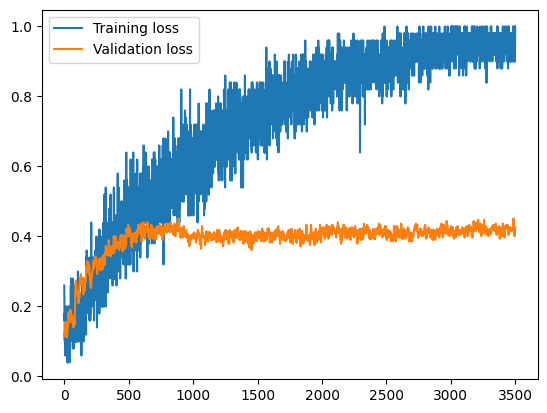

In [ ]:
init_variables()
total_iterations = 0
optimize(num_iterations = 3500, X = 250)

> Kao što se može videti, model ima tendenciju da se preprilagodi (overfitting) i nije baš dobar.

8 - CNN sa TensorFlow-om - Rezultati
> Rezultati nisu tako dobri jer je tačnost samo 44%. Korišćenje unapred obučenog modela bi dalo bolji rezultat.

> Povećanje tačnosti se može postići dodavanjem više fotografija pasa. Možemo kreirati "nove" slike u trening skupu podataka rotiranjem postojećih slika. Ovaj proces se naziva augmentacija slika. Augmentacija će pomoći da prepozna obrasce koji mogu imati različite 'pozicije' u prostoru.

> Ispod se nalaze funkcije za prikazivanje slika iz novog testnog skupa sa odgovarajućim rasama i predviđenim rasama. Postoji i matrica konfuzije za pregled rezultata.

In [ ]:
def plot_images(images, cls_true, cls_pred = None):
  assert len(images) == len(cls_true) == 12

  # Kreiranje slike sa 3x3 podgrafa

  fig, axes = plt.subplots(4, 3)
  fig.subplots_adjust(hspace = 0.3)

  for i, ax in enumerate(axes.flat):
    # Crtanje slike
    ax.imshow(images[i].reshape(img_shape), cmap = 'binary')

    # Prikaz stvarnih i predviđenih klasa
    if cls_pred is None:
      xlabel = "True: {0}".format(cls_true[i])
    else:
      xlabel = "True: {0},Pred: {1}".format(cls_true[i], cls_pred[i])

    # Prikaz klasa kao oznaka (labela) na x-osi
    ax.set_xlabel(xlabel)

    # Uklanjanje oznaka sa grafa
    ax.set_xticks([])
    ax.set_yticks([])

  plt.show()

In [ ]:
def plot_confusion_matrix(data_pred_cls, data_predicted_cls):
  # Ovo se poziva iz print_test_accuracy() ispod.

  # cls_pred je niz predviđenih klasa za sve slike u test skupu.

  # Matricu konfuzije dobijamo iz biblioteke sklearn
  cm = confusion_matrix(y_true = data_pred_cls,
                        y_pred = data_predicted_cls)

  # Ispisujemo matricu konfuzije kao tekst
  print(cm)

  # Prikazujemo matricu konfuzije kao sliku (graf)
  plt.matshow(cm)

  # Pravimo različita prilagođavanja grafiku
  plt.colorbar()
  ticks_marks = np.arange(num_classes)
  plt.xticks(ticks_marks, range(num_classes))
  plt.yticks(ticks_marks, range(num_classes))
  plt.xlabel('Predviđene')
  plt.ylabel('Stvarne')

  plt.show()


> Pogledajmo neke rezultate

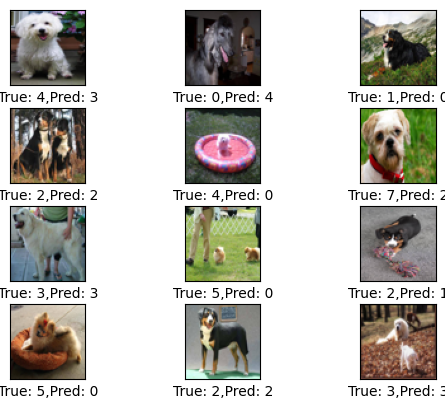

In [ ]:
feed_dict_validation = {x: X_validation,
                        y_true: y_validation,
                        keep_prob_conv : 1,
                        keep_prob_fc : 1}

df_validation_Predicted_cls = session.run(y_pred_cls,
                                          feed_dict = feed_dict_validation)

plot_images(images = X_validation[50:62],
            cls_true = df_validation_toPred_cls[50:62],
            cls_pred = df_validation_Predicted_cls[50:62])

Stvarne: 7 / shih-tzu
Predviđene: 7 / shih-tzu


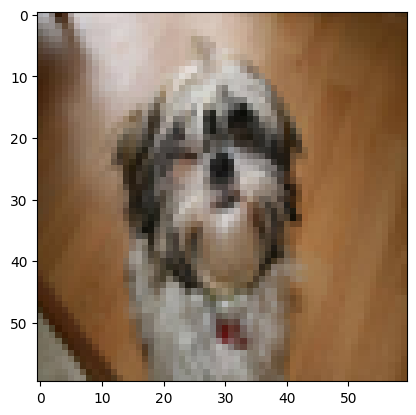

In [ ]:
i = 63

print(("Stvarne: {0} / {1}").format(df_validation_toPred_cls[i],
                                    labels_name[df_validation_toPred_cls[i]]))

print(("Predviđene: {0} / {1}").format(df_validation_Predicted_cls[i],
                                       labels_name[df_validation_Predicted_cls[i]]))

lum = X_validation[i,:,:,:]

plt.imshow(lum)
plt.show()

[[13  1  3  1  2  3  6  2]
 [ 1 18 14  1  2  0  0  3]
 [ 1  6 24  1  0  0  2  2]
 [ 1  3  0 10  7  2  6  5]
 [ 3  0  1  9  9  9  1  2]
 [ 7  1  0  4  1 16  0  0]
 [ 4  1  3  6  1  2 17  0]
 [ 3  1  3  6  5  6  5 11]]


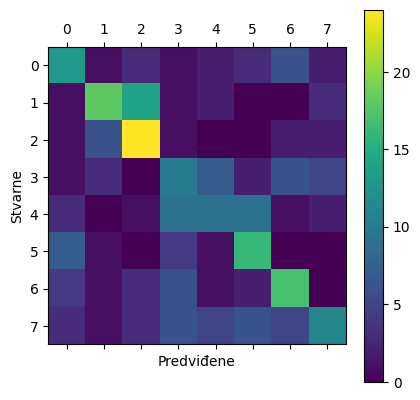

In [ ]:
plot_confusion_matrix(df_validation_toPred_cls, df_validation_Predicted_cls)

> Kao što se može videti, model ima teškoće u razlikovanju Rase 1: Bernski pastirski pas (bernese_mountain_dog) i Rase 2: Entlebuški pastirski pas(entlebucher). Ove dve rase izgledaju veoma slično (iste boja dlake i oblik). Dakle, sasvim je normalno da je naš model napravio neke greške između ove dve rase.

# Korišćenje unapred treniranog modela

Dosta prethodno obučenih modela je dostupno u većini framworka za mašinsko učenje, kao što su PyTorch i Keras.

Mi ćemo koristiti prethodno obučene vrhunske CNN modele kako bismo klasifikovali različite rase pasa na osnovu ulaznih slika pasa. Koristićemo Keras biblioteku za duboko učenje i podržane funkcionalnosti za naš model dubokog učenja.

Arhitekture CNN-a uključuju VGG16, Xception, Inception i [Xception+Inception] ansambl putem spajanja vektora izvađenih karakteristika.

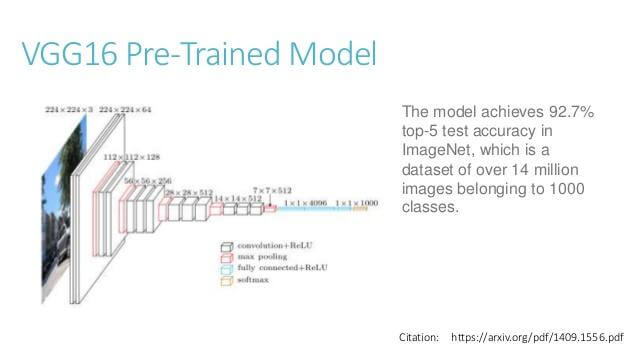

Ponovo ćemo importovati biblioteke

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm # Fancy progress bars

from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3

Učitavanje Kerasaovih unapred treniranih modela

In [3]:
!ls /content/drive/MyDrive/Dataset/KerasPretrainedModels/

imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [4]:
# Kreiramo Keras direktorijume za keširanje kako bismo učitali prethodno obučene modele.
cache_dir = expanduser(join('~', '.keras')) # Direktorijum za keširanje
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models') # Models directory
if not exists(models_dir):
    makedirs(models_dir)

# Kopiramo odabrane datoteke naših prethodno obučenih modela u Keras direktorijum za keširanje kako bi Keras mogao da im pristupi.
# Selekcija uključuje sve modele označene kao "notop", kao i oba resnet50 modela.
!cp /content/drive/MyDrive/Dataset/KerasPretrainedModels/*notop* ~/.keras/models/
!cp /content/drive/MyDrive/Dataset/KerasPretrainedModels/imagenet_class_index.json ~/.keras/models/
!cp /content/drive/MyDrive/Dataset/KerasPretrainedModels/resnet50* ~/.keras/models/

# Prikaz modela iz keš direktorijuma
!ls ~/.keras/models

imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


Opet ćemo koristiti podskup ukupnog broja podataka radi bržeg rada

In [5]:
INPUT_SIZE = 224
NUM_CLASSES = 8
SEED = 7

# Read the y-true-labels file as well as the prediction file
data_dir = '/content/drive/MyDrive/Dataset'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))

print("Broj fajlova vezanih za treniranje: " + str(len(listdir(join(data_dir, 'train')))) + " | Trening labele: "
      + str(len(labels)))
print("Broj fajlova vezanih za testiranje: " + str(len(listdir(join(data_dir, 'test')))) + " | Broj testnih predikcija: "
     + str(len(sample_submission)))

Broj fajlova vezanih za treniranje: 10225 | Trening labele: 10222
Broj fajlova vezanih za testiranje: 10357 | Broj testnih predikcija: 10357


In [6]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
group = labels.groupby(by='breed', as_index=False).agg({'id': pd.Series.nunique})
group = group.sort_values('id',ascending=False)
print(group)
labels['rank'] = group['breed']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))

# Trening / validaciona podela na 80%/20%
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
y_train = labels_pivot[selected_breed_list].values
ytr = y_train[train_idx]
yv = y_train[valid_idx]

                  breed   id
6    scottish_deerhound  126
4           maltese_dog  117
0          afghan_hound  116
2           entlebucher  115
1  bernese_mountain_dog  114
7              shih-tzu  112
3        great_pyrenees  111
5            pomeranian  111


<ipython-input-6-98c59b24109c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['target'] = 1
<ipython-input-6-98c59b24109c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['rank'] = group['breed']
<ipython-input-6-98c59b24109c>:8: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)


In [7]:
def read_img(img_id, train_or_test, size):
    """
    Čitanje i promena veličine slike.
    # Args:
        img_id: putanja do slike
        train_or_test: string "train" ili "test"
        size: nova veličina slike
    # Vraća:
        Sliku kao numpy niz
    """
    img = image.load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size = size)
    img = image.img_to_array(img)
    return img

Ekstrakcija reprezentacija karakteristika slika: VGG16 mreža

In [13]:
INPUT_SIZE = 224
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype = 'float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Oblik trening slika: {} veličina: {:,}'.format(x_train.shape, x_train.size))

922it [00:06, 135.73it/s]

Oblik trening slika: (922, 224, 224, 3) veličina: 138,786,816


In [14]:
# Razdvajanje trening i validacionih podataka putem indeksa
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print("X_train oblik: " + str(Xtr.shape))
print("y_train oblik: " + str(ytr.shape))
print("X_val oblik: " + str(Xv.shape))
print("y_val oblik: " + str(yv.shape))

# Ekstrakcija karakteristika sažimanja slika ("bf" - bottleneck features)
vgg_bottleneck = VGG16(weights='imagenet', include_top=False, pooling=POOLING)
train_vgg_bf = vgg_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_vgg_bf = vgg_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Oblik karakteristika sažimanja trening skupa za VGG: {} veličina: {:,}'.format(train_vgg_bf.shape, train_vgg_bf.size))
print('Oblik karakteristika sažimanja validacionog skupa za VGG: {} veličina: {:,}'.format(valid_vgg_bf.shape, valid_vgg_bf.size))
print("Karakteristike sažimanja VGG trebale bi biti vektor dimenzija 512 za svaki primer slike / predikciju.")

X_train oblik: (729, 224, 224, 3)
y_train oblik: (729, 8)
X_val oblik: (193, 224, 224, 3)
y_val oblik: (193, 8)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Oblik karakteristika sažimanja trening skupa za VGG: (729, 512) veličina: 373,248
Oblik karakteristika sažimanja validacionog skupa za VGG: (193, 512) veličina: 98,816
Karakteristike sažimanja VGG trebale bi biti vektor dimenzija 512 za svaki primer slike / predikciju.


Logistička regresija na ekstrahovanim karakteristikama sažimanja: VGG16
Napomena: Takođe bismo mogli dodati potpuno povezani sloj na kraj prethodno obučene mreže. Ovo bi radilo, iako bi zahtevalo više računarskih resursa.

In [15]:
# Optimizator: Limited-memory BFGS (L-BFGS)
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_vgg_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_vgg_bf)
valid_preds = logreg.predict(valid_vgg_bf)

print('VGG LogLoss validacije {}'.format(log_loss(yv, valid_probs)))
print('Tačnost validacije za VGG {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

VGG LogLoss validacije 0.34150275920438233
Tačnost validacije za VGG 0.9067357512953368


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Ekstrakcija reprezentacija karakteristika slika: Xception mreža

In [17]:
INPUT_SIZE = 299
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print("Oblik trening slika: {} veličina: {:,}".format(x_train.shape, x_train.size))

922it [00:09, 101.68it/s]

Oblik trening slika: (922, 299, 299, 3) veličina: 247,283,166


In [18]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print("X_train oblik: " + str(Xtr.shape))
print("y_train oblik: " + str(ytr.shape))
print("X_val oblik: " + str(Xv.shape))
print("y_val oblik: " + str(yv.shape))

xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Oblik karakteristika sažimanja skupa za Xception: {} veličina: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Oblik karakteristika sažimanja validacionog skupa za Xcpetion: {} veličina: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

Instructions for updating:
Colocations handled automatically by placer.


X_train oblik: (729, 299, 299, 3)
y_train oblik: (729, 8)
X_val oblik: (193, 299, 299, 3)
y_val oblik: (193, 8)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Oblik karakteristika sažimanja skupa za Xception: (729, 2048) veličina: 1,492,992
Oblik karakteristika sažimanja validacionog skupa za Xcpetion: (193, 2048) veličina: 395,264


Logistička regresija na ekstrahovanim karakteristikama sažimanja: Xcpetion

In [19]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)
print("LogLoss validacija za Xception {}".format(log_loss(yv, valid_probs)))
print("Tačnost validacije za Xception {}".format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

LogLoss validacija za Xception 0.07939534969241356
Tačnost validacije za Xception 0.9844559585492227


## Ekstrakcija reprezentacija karakteristika slika: Inception mreža

In [20]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print("X_train oblik: " + str(Xtr.shape))
print("y_train oblik: " + str(ytr.shape))
print("X_val oblik: " + str(Xv.shape))
print("y_val oblik: " + str(yv.shape))

inception_bottleneck = inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling=POOLING)
train_i_bf = inception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_i_bf = inception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Oblik karakteristika sažimanja trening skupa za InceptionV3: {} veličina: {:,}'.format(train_i_bf.shape, train_i_bf.size))
print('Oblik karakteristika sažimanja validacionog skupa za InceptionV3: {} veličina: {:,}'.format(valid_i_bf.shape, valid_i_bf.size))

X_train oblik: (729, 299, 299, 3)
y_train oblik: (729, 8)
X_val oblik: (193, 299, 299, 3)
y_val oblik: (193, 8)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Oblik karakteristika sažimanja trening skupa za InceptionV3: (729, 2048) veličina: 1,492,992
Oblik karakteristika sažimanja validacionog skupa za InceptionV3: (193, 2048) veličina: 395,264


Logistička regresija na ekstrahovanim karakteristikama sažimanja: Inception mreža

In [21]:
logreg = LogisticRegression(multi_class='multinomial', solver = 'lbfgs', random_state=SEED)
logreg.fit(train_i_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_i_bf)
valid_preds = logreg.predict(valid_i_bf)

print('LogLoss validacije za Inception {}'.format(log_loss(yv, valid_probs)))
print('Tačnost validacije za Inception {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

LogLoss validacije za Inception 0.052970382016374246
Tačnost validacije za Inception 0.9792746113989638


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Logistička regresija na kombinaciji ekstrahovanih karakteristika: [Xception + Inception]

>Iskorišćavanje mogućnosti ekstrahovanja karakteristika više prethodno obučenih modela

>Prednost korišćenja zasebnog nezavisnog klasifikatora umesto dodavanja potpuno povezanih slojeva svakoj od ovih mreža: lakše ansambliranje

In [22]:
X = np.hstack([train_x_bf, train_i_bf]) # This is a array-concat function that stacks horizontally instead of vertically
V = np.hstack([valid_x_bf, valid_i_bf])
print("Oblik karakteristika sažimanja tokom potpunog treninga: {} veličina: {:,}".format(X.shape, X.size))
print("Oblik karakteristika sažimanja tokom potpune validacije: {} veličina: {:,}".format(V.shape, V.size))

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(X, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(V)
valid_preds = logreg.predict(V)
print("Validation Xception+Inception LogLoss {}".format(log_loss(yv, valid_probs)))
print("Validation Xception+Inception Accuracy {}".format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1),
                                                                        valid_preds)))

Oblik karakteristika sažimanja tokom potpunog treninga: (729, 4096) veličina: 2,985,984
Oblik karakteristika sažimanja tokom potpune validacije: (193, 4096) veličina: 790,528
Validation Xception+Inception LogLoss 0.05219271856294813
Validation Xception+Inception Accuracy 0.9792746113989638


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Sažetak i provera grešaka

Primećujemo da Xception+Inception ansambl ima dobre performanse na datom problemu klasifikacije, postižući LogLoss ispod 0.12 i tačnost veću od 96.5%.

Ispod su neki primeri netačnih klasifikacija modela.

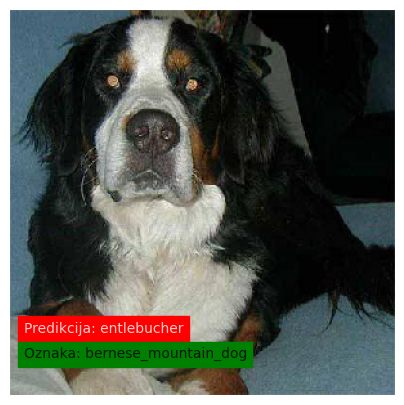

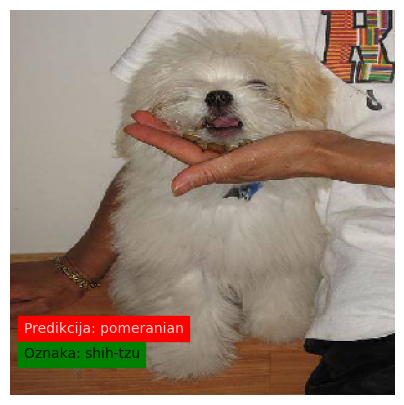

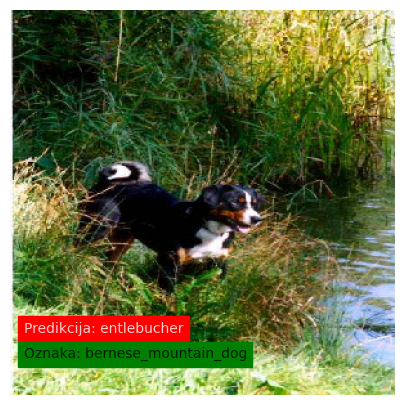

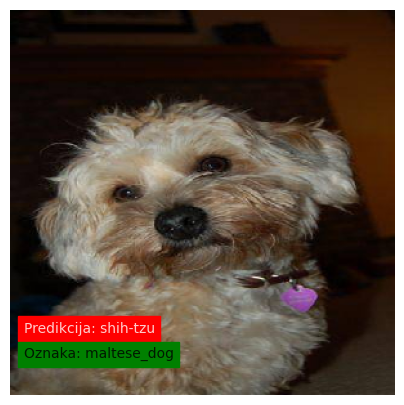

In [23]:
valid_breeds = (yv * range(NUM_CLASSES)).sum(axis=1)
error_idx = (valid_breeds != valid_preds)
for img_id, breed, pred in zip(labels.loc[valid_idx, 'id'].values[error_idx],
                               [selected_breed_list[int(b)] for b in valid_preds[error_idx]],
                               [selected_breed_list[int(b)] for b in valid_breeds[error_idx]]):
    fix, ax = plt.subplots(figsize=(5,5,))
    img = read_img(img_id, 'train', (299,299))
    ax.imshow(img/255)
    ax.text(10, 250, 'Predikcija: %s' % pred, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 270, 'Oznaka: %s' % breed, color='k', backgroundcolor='g', alpha=0.8)
    ax.axis('off')
    plt.show()

# Zaključak

Klasifikacija slika je kao tema veoma interesantna i često primenjivana u današnjem vremenu.<br>
Upoznali smo se  sa  nekim  od primera  primene  same  klasifikacije,  a  koliko  je  tema rasprostranjena govori to da se koristi i za biomedicinsko snimanje,   biometriju,   video-nadzor,   navigaciju   vozila, industrijski vizuelni pregled, navigaciju robota i daljinsko istraživanje. <br> <br>
Prvo smo samostalno kreirali model od početka, koji je vršio klasifikaciju samo 8 najpopularnijih rasa iz seta podataka. Nakon toga smo koristili modele koji su već prethodno trenirani i nad njima smo klasifikovali set podataka rase pasa. <br>
Mogli  smo  da  primetimo  da  korišćenje unapred treniranog modela dosta ubrzava i olakšava samu klasifikaciju, a da se pri tom još i dobija na tačnosti i pouzdanosti modela. Kombinacija Xception i Inception modela je imala tačnost od odličnih 97.9 %, a LogLoss od samo 5 %, dok je inicijalni model imao tačnost od samo 42.6%. Takođe, moglo se primetiti da iako je kvalitet slika bio znatno veći u unapred treniranim modelima, oni su i dalje znatno brže izvršili klasifikaciju. <br> <br>
Mašinsko učenje, a samim tim i klasifikacija slika, imaju veliki potencijal za daljim napretkom i može se reći da je neminovno da će ove tehnologije da rešavaju realne probleme sa kojima se moderno društvo suočava.


# Literatura

1.   <a href="https://www.kaggle.com">Kaggle</a>
2.   <a href="https://keras.io/">Keras</a>
3.   <a href="https://www.tensorflow.org/">TensorFlow</a>
4.   <a href="https://medium.com/nanonets">How to build a classification model</a>
5.   <a href="https://doi.org/10.24867/08BE13Antic">Klasifikacija slika primenom fastai biblioteke (Jovana Antić)</a>



